

# Proposal use line search to improve ADAM optimizer



In [ ]:
import torchvision
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
from sklearn import metrics
import numpy as np
import tqdm
import contextlib


from torch.autograd import Variable
import time 
import copy
import pandas as pd
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import math
from torch.optim import Optimizer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


First,We define model and some function


In [ ]:
class Mlp(nn.Module):
    def __init__(self, input_size=784,
                 hidden_sizes=[512,256],
                 n_classes=10,
                 bias=True, dropout=False):
        super().__init__()

        self.dropout=dropout
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList([nn.Linear(in_size, out_size, bias=bias) for
                                            in_size, out_size in zip([self.input_size] + hidden_sizes[:-1], hidden_sizes)])
        self.output_layer = nn.Linear(hidden_sizes[-1], n_classes, bias=bias)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        out = x
        for layer in self.hidden_layers:
            Z = layer(out)
            out = F.relu(Z)

            if self.dropout:
                out = F.dropout(out, p=0.5)

        logits = self.output_layer(out)

        return logits
def softmax_loss(model, images, labels, backwards=False):

    logits = model(Variable(images.view(-1, 28 * 28)))

    criterion = torch.nn.CrossEntropyLoss(reduction="mean")
    
    loss = criterion(logits, labels.view(-1))

    if backwards and loss.requires_grad:
        loss.backward()

    return loss
def softmax_accuracy(model, images, labels):
    images = Variable(images.view(-1, 28 * 28))
    logits = model(images)
    pred_labels = logits.argmax(dim=1)
    acc = (pred_labels == labels).float().mean()

    return acc
@torch.no_grad()
def compute_metric_on_dataset(model, dataset, metric_name):
    metric_function = get_metric_function(metric_name)
    
    model.eval()

    loader = DataLoader(dataset, drop_last=False, batch_size=1024)
    print("> Computing %s..." % (metric_name))

    score_sum = 0.
    for images, labels in tqdm.notebook.tqdm_notebook(loader):
        
        score_sum += metric_function(model, images, labels).item() * images.shape[0] 
            
    score = float(score_sum / len(loader.dataset))

    return score
def get_metric_function(metric_name):
    if metric_name == "softmax_accuracy":
        return softmax_accuracy

    elif metric_name == "softmax_loss":
        return softmax_loss
                         

In [ ]:
def check_armijo_conditions(step_size, step_size_old, loss, grad_norm,
                      loss_next, c, beta_b):
    found = 0

    # computing the new break condition
    break_condition = loss_next - \
        (loss - (step_size) * c * grad_norm**2)
    if (break_condition <= 0):
        found = 1

    else:
        # decrease the step-size by a multiplicative factor
        step_size = step_size * beta_b

    return found, step_size, step_size_old
def reset_step(step_size, n_batches_per_epoch=None, gamma=None, reset_option=1,
               init_step_size=None):
    if reset_option == 0:
        pass

    elif reset_option == 1:
        step_size = step_size * gamma**(1. / n_batches_per_epoch)

        
    elif reset_option == 2:
        step_size = init_step_size

    return step_size



def compute_grad_norm(grad_list):
    grad_norm = 0.
    for g in grad_list:
        if g is None:
            continue
        grad_norm += torch.sum(torch.mul(g, g))
    grad_norm = np.sqrt(grad_norm)
    return grad_norm


def get_grad_list(params):

    return [p.grad for p in params]

@contextlib.contextmanager
def random_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)
@contextlib.contextmanager
def random_seed_torch(seed, device=0):
    cpu_rng_state = torch.get_rng_state()
    if torch.cuda.is_available():
        gpu_rng_state = torch.cuda.get_rng_state(0)

    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    try:
        yield
    finally:
        torch.set_rng_state(cpu_rng_state)
        if torch.cuda.is_available():
            torch.cuda.set_rng_state(gpu_rng_state, device)

In [ ]:
exp_dict={
    "acc_func": "softmax_accuracy",
    "batch_size": 128,
    "dataset": "mnist",
    "loss_func": "softmax_loss",
    "max_epoch": 100,
    "model": "linear",
    "opt": {
        "gamma": 2,
        "name": "sgd_armijo"
    },
    "runs": 0
}

Second, we load data 

In [ ]:
seed = 42 + exp_dict['runs']
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

    # Dataset
    # -----------
datadir='/content/gdrive/MyDrive/DATA_NCKHSV'
train_flag=True
    # Load Train Dataset
train_set = torchvision.datasets.MNIST(datadir, train=train_flag,
                            download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                    (0.5,), (0.5,))
                            ]))

train_loader = torch.utils.data.DataLoader(train_set,
                          drop_last=True,
                          shuffle=True,
                          batch_size=exp_dict["batch_size"])

# Load Val Dataset
val_set =  torchvision.datasets.MNIST(datadir, train=False,
                            download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                    (0.5,), (0.5,))
                            ]))

In [ ]:
 n_batches_per_epoch = len(train_set)/float(exp_dict["batch_size"])

And then, We implement optimizer Adam



In [ ]:
def try_adam_update(params, step_size, params_current, delta):
    zipped = zip(params, params_current, delta)
    for p_next, p_current, d in zipped:
        p_next.data = p_current - step_size * d
def compute_monment_and_variable(moment,variance,exp_avg_, exp_avg_sq_,betas,grad_current,step):
    b1, b2 = betas
    for i in range(len(moment)):
      exp_avg_[i]=exp_avg_[i]*b1+grad_current[i]*(1-b1)
      exp_avg_sq_[i] =exp_avg_sq_[i]*b2 +(grad_current[i]**2)*(1-b2)
      moment[i]=exp_avg_[i]/(1 - b1 ** step)
      variance[i]=exp_avg_sq_[i]/(1 - b2 ** step)
    return moment,variance,exp_avg_, exp_avg_sq_
def compute_delta(moment,variance,epsilon):
    deltas=[]
    for i in range(len(moment)):
      delta=moment[i]/(variance[i].sqrt()+epsilon)
      deltas.append(delta)
    return deltas

In [ ]:
#@title
class original_adam(torch.optim.Optimizer):

    def __init__(self,
                 params,
                 init_step_size=1,
                 betas=(0.9, 0.99), 
                 eps=1e-8,
               
                 ):
        defaults = dict(
                        init_step_size=init_step_size,
                        betas=betas,
                        eps=1e-8,
                        )
        super().__init__(params, defaults)       

        self.state['step'] = 0
        self.state['step_size'] = init_step_size

        self.state['n_forwards'] = 0
        self.state['n_backwards'] = 0

    def step(self, closure):
        seed = time.time()
        def closure_deterministic():
            with random_seed_torch(int(seed)):
                return closure()

        step_size = self.state['step_size']

        loss = closure_deterministic()
        loss.backward()

        self.state['n_forwards'] += 1
        self.state['n_backwards'] += 1

        for group in self.param_groups:
            params = group["params"]
            params_current = copy.deepcopy(params)
            grad_current = [p.grad for p in params]
            b1, b2 = group['betas']
            if self.state['step'] == 0 :

              self.state['exp_avg'] = [torch.zeros_like(p.data) for p in group["params"]]
              self.state['monment']=self.state['exp_avg']

              self.state['exp_avg_sq'] = [torch.zeros_like(p.data) for p in group["params"]]
              self.state['variable']=self.state['exp_avg_sq']
            else:
              self.state['monment'],self.state['variable'],self.state['exp_avg'], self.state['exp_avg_sq']=compute_monment_and_variable(self.state['monment'],self.state['variable'],self.state['exp_avg'],self.state['exp_avg_sq'],group['betas'],grad_current,self.state['step']+1)
            delta=compute_delta(self.state['monment'],self.state['variable'],group['eps'])
            try_adam_update(params,step_size, params_current, delta)
            self.state['step'] += 1

        return loss

In [ ]:
#@title
model = Mlp(n_classes=10, dropout=False)
loss_function=softmax_loss
opt =original_adam(params=model.parameters(),# opt_dict.get("c") or
        init_step_size=1e-3,
        )

In [ ]:
#@title
#@ adam 
score_list = []
s_epoch = 0
metrics_flag=True
print('Starting experiment at epoch %d/%d' % (s_epoch, exp_dict['max_epoch']))

for epoch in range(s_epoch, exp_dict['max_epoch']):
    # Set seed
    np.random.seed(exp_dict['runs']+epoch)
    torch.manual_seed(exp_dict['runs']+epoch)
    torch.cuda.manual_seed_all(exp_dict['runs']+epoch)

    score_dict = {"epoch": epoch}
    if metrics_flag:
        # 1. Compute train loss over train set
        score_dict["train_loss"] =compute_metric_on_dataset(model, train_set,
                                            metric_name=exp_dict["loss_func"])

        # 2. Compute val acc over val set
        score_dict["val_acc"] =compute_metric_on_dataset(model, val_set,
                                                    metric_name=exp_dict["acc_func"])

    #3. Train over train loader
    model.train()
    print("%d - Training model with %s..." % (epoch, exp_dict["loss_func"]))

    s_time = time.time()
    for images,labels in tqdm.notebook.tqdm_notebook(train_loader):
        images, labels = images, labels

        opt.zero_grad()

        closure = lambda : loss_function(model, images, labels, backwards=False)
        opt.step(closure)
    e_time = time.time()
    score_dict["step_size"] = opt.state["step_size"]
    score_dict["n_forwards"] = opt.state["n_forwards"]
    score_dict["n_backwards"] = opt.state["n_backwards"]


    score_list += [score_dict]
    
    print(pd.DataFrame(score_list).tail())

Starting experiment at epoch 0/100
> Computing softmax_loss...



> Computing softmax_accuracy...



0 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.306769   0.1238      0.001         468          468
> Computing softmax_loss...



> Computing softmax_accuracy...



1 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.306769   0.1238      0.001         468          468
1      1    2.169064   0.2405      0.001         936          936
> Computing softmax_loss...



> Computing softmax_accuracy...



2 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.306769   0.1238      0.001         468          468
1      1    2.169064   0.2405      0.001         936          936
2      2    2.167885   0.2427      0.001        1404         1404
> Computing softmax_loss...



> Computing softmax_accuracy...



3 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.306769   0.1238      0.001         468          468
1      1    2.169064   0.2405      0.001         936          936
2      2    2.167885   0.2427      0.001        1404         1404
3      3    2.157073   0.2617      0.001        1872         1872
> Computing softmax_loss...



> Computing softmax_accuracy...



4 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.306769   0.1238      0.001         468          468
1      1    2.169064   0.2405      0.001         936          936
2      2    2.167885   0.2427      0.001        1404         1404
3      3    2.157073   0.2617      0.001        1872         1872
4      4    2.146197   0.2713      0.001        2340         2340
> Computing softmax_loss...



> Computing softmax_accuracy...



5 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
1      1    2.169064   0.2405      0.001         936          936
2      2    2.167885   0.2427      0.001        1404         1404
3      3    2.157073   0.2617      0.001        1872         1872
4      4    2.146197   0.2713      0.001        2340         2340
5      5    2.135323   0.2811      0.001        2808         2808
> Computing softmax_loss...



> Computing softmax_accuracy...



6 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
2      2    2.167885   0.2427      0.001        1404         1404
3      3    2.157073   0.2617      0.001        1872         1872
4      4    2.146197   0.2713      0.001        2340         2340
5      5    2.135323   0.2811      0.001        2808         2808
6      6    2.123591   0.2873      0.001        3276         3276
> Computing softmax_loss...



> Computing softmax_accuracy...



7 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
3      3    2.157073   0.2617      0.001        1872         1872
4      4    2.146197   0.2713      0.001        2340         2340
5      5    2.135323   0.2811      0.001        2808         2808
6      6    2.123591   0.2873      0.001        3276         3276
7      7    2.095225   0.2813      0.001        3744         3744
> Computing softmax_loss...



> Computing softmax_accuracy...



8 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
4      4    2.146197   0.2713      0.001        2340         2340
5      5    2.135323   0.2811      0.001        2808         2808
6      6    2.123591   0.2873      0.001        3276         3276
7      7    2.095225   0.2813      0.001        3744         3744
8      8    1.942203   0.4668      0.001        4212         4212
> Computing softmax_loss...



> Computing softmax_accuracy...



9 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
5      5    2.135323   0.2811      0.001        2808         2808
6      6    2.123591   0.2873      0.001        3276         3276
7      7    2.095225   0.2813      0.001        3744         3744
8      8    1.942203   0.4668      0.001        4212         4212
9      9    1.795007   0.4693      0.001        4680         4680
> Computing softmax_loss...



> Computing softmax_accuracy...



10 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
6       6    2.123591   0.2873      0.001        3276         3276
7       7    2.095225   0.2813      0.001        3744         3744
8       8    1.942203   0.4668      0.001        4212         4212
9       9    1.795007   0.4693      0.001        4680         4680
10     10    1.733029   0.4596      0.001        5148         5148
> Computing softmax_loss...



> Computing softmax_accuracy...



11 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
7       7    2.095225   0.2813      0.001        3744         3744
8       8    1.942203   0.4668      0.001        4212         4212
9       9    1.795007   0.4693      0.001        4680         4680
10     10    1.733029   0.4596      0.001        5148         5148
11     11    1.694011   0.4717      0.001        5616         5616
> Computing softmax_loss...



> Computing softmax_accuracy...



12 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
8       8    1.942203   0.4668      0.001        4212         4212
9       9    1.795007   0.4693      0.001        4680         4680
10     10    1.733029   0.4596      0.001        5148         5148
11     11    1.694011   0.4717      0.001        5616         5616
12     12    1.664281   0.4506      0.001        6084         6084
> Computing softmax_loss...



> Computing softmax_accuracy...



13 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
9       9    1.795007   0.4693      0.001        4680         4680
10     10    1.733029   0.4596      0.001        5148         5148
11     11    1.694011   0.4717      0.001        5616         5616
12     12    1.664281   0.4506      0.001        6084         6084
13     13    1.639806   0.4508      0.001        6552         6552
> Computing softmax_loss...



> Computing softmax_accuracy...



14 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
10     10    1.733029   0.4596      0.001        5148         5148
11     11    1.694011   0.4717      0.001        5616         5616
12     12    1.664281   0.4506      0.001        6084         6084
13     13    1.639806   0.4508      0.001        6552         6552
14     14    1.621712   0.4553      0.001        7020         7020
> Computing softmax_loss...



> Computing softmax_accuracy...



15 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
11     11    1.694011   0.4717      0.001        5616         5616
12     12    1.664281   0.4506      0.001        6084         6084
13     13    1.639806   0.4508      0.001        6552         6552
14     14    1.621712   0.4553      0.001        7020         7020
15     15    1.593839   0.4635      0.001        7488         7488
> Computing softmax_loss...



> Computing softmax_accuracy...



16 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
12     12    1.664281   0.4506      0.001        6084         6084
13     13    1.639806   0.4508      0.001        6552         6552
14     14    1.621712   0.4553      0.001        7020         7020
15     15    1.593839   0.4635      0.001        7488         7488
16     16    1.567707   0.4705      0.001        7956         7956
> Computing softmax_loss...



> Computing softmax_accuracy...



17 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
13     13    1.639806   0.4508      0.001        6552         6552
14     14    1.621712   0.4553      0.001        7020         7020
15     15    1.593839   0.4635      0.001        7488         7488
16     16    1.567707   0.4705      0.001        7956         7956
17     17    1.552279   0.4732      0.001        8424         8424
> Computing softmax_loss...



> Computing softmax_accuracy...



18 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
14     14    1.621712   0.4553      0.001        7020         7020
15     15    1.593839   0.4635      0.001        7488         7488
16     16    1.567707   0.4705      0.001        7956         7956
17     17    1.552279   0.4732      0.001        8424         8424
18     18    1.528886   0.4714      0.001        8892         8892
> Computing softmax_loss...



> Computing softmax_accuracy...



19 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
15     15    1.593839   0.4635      0.001        7488         7488
16     16    1.567707   0.4705      0.001        7956         7956
17     17    1.552279   0.4732      0.001        8424         8424
18     18    1.528886   0.4714      0.001        8892         8892
19     19    1.512818   0.4764      0.001        9360         9360
> Computing softmax_loss...



> Computing softmax_accuracy...



20 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
16     16    1.567707   0.4705      0.001        7956         7956
17     17    1.552279   0.4732      0.001        8424         8424
18     18    1.528886   0.4714      0.001        8892         8892
19     19    1.512818   0.4764      0.001        9360         9360
20     20    1.494831   0.4827      0.001        9828         9828
> Computing softmax_loss...



> Computing softmax_accuracy...



21 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
17     17    1.552279   0.4732      0.001        8424         8424
18     18    1.528886   0.4714      0.001        8892         8892
19     19    1.512818   0.4764      0.001        9360         9360
20     20    1.494831   0.4827      0.001        9828         9828
21     21    1.474852   0.4897      0.001       10296        10296
> Computing softmax_loss...



> Computing softmax_accuracy...



22 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
18     18    1.528886   0.4714      0.001        8892         8892
19     19    1.512818   0.4764      0.001        9360         9360
20     20    1.494831   0.4827      0.001        9828         9828
21     21    1.474852   0.4897      0.001       10296        10296
22     22    1.433703   0.5045      0.001       10764        10764
> Computing softmax_loss...



> Computing softmax_accuracy...



23 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
19     19    1.512818   0.4764      0.001        9360         9360
20     20    1.494831   0.4827      0.001        9828         9828
21     21    1.474852   0.4897      0.001       10296        10296
22     22    1.433703   0.5045      0.001       10764        10764
23     23    1.305382   0.5820      0.001       11232        11232
> Computing softmax_loss...



> Computing softmax_accuracy...



24 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
20     20    1.494831   0.4827      0.001        9828         9828
21     21    1.474852   0.4897      0.001       10296        10296
22     22    1.433703   0.5045      0.001       10764        10764
23     23    1.305382   0.5820      0.001       11232        11232
24     24    1.206123   0.6232      0.001       11700        11700
> Computing softmax_loss...



> Computing softmax_accuracy...



25 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
21     21    1.474852   0.4897      0.001       10296        10296
22     22    1.433703   0.5045      0.001       10764        10764
23     23    1.305382   0.5820      0.001       11232        11232
24     24    1.206123   0.6232      0.001       11700        11700
25     25    1.141247   0.6440      0.001       12168        12168
> Computing softmax_loss...



> Computing softmax_accuracy...



26 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
22     22    1.433703   0.5045      0.001       10764        10764
23     23    1.305382   0.5820      0.001       11232        11232
24     24    1.206123   0.6232      0.001       11700        11700
25     25    1.141247   0.6440      0.001       12168        12168
26     26    1.101851   0.6578      0.001       12636        12636
> Computing softmax_loss...



> Computing softmax_accuracy...



27 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
23     23    1.305382   0.5820      0.001       11232        11232
24     24    1.206123   0.6232      0.001       11700        11700
25     25    1.141247   0.6440      0.001       12168        12168
26     26    1.101851   0.6578      0.001       12636        12636
27     27    1.069095   0.6641      0.001       13104        13104
> Computing softmax_loss...



> Computing softmax_accuracy...



28 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
24     24    1.206123   0.6232      0.001       11700        11700
25     25    1.141247   0.6440      0.001       12168        12168
26     26    1.101851   0.6578      0.001       12636        12636
27     27    1.069095   0.6641      0.001       13104        13104
28     28    1.048832   0.6717      0.001       13572        13572
> Computing softmax_loss...



> Computing softmax_accuracy...



29 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
25     25    1.141247   0.6440      0.001       12168        12168
26     26    1.101851   0.6578      0.001       12636        12636
27     27    1.069095   0.6641      0.001       13104        13104
28     28    1.048832   0.6717      0.001       13572        13572
29     29    1.023787   0.6784      0.001       14040        14040
> Computing softmax_loss...



> Computing softmax_accuracy...



30 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
26     26    1.101851   0.6578      0.001       12636        12636
27     27    1.069095   0.6641      0.001       13104        13104
28     28    1.048832   0.6717      0.001       13572        13572
29     29    1.023787   0.6784      0.001       14040        14040
30     30    1.000304   0.6901      0.001       14508        14508
> Computing softmax_loss...



> Computing softmax_accuracy...



31 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
27     27    1.069095   0.6641      0.001       13104        13104
28     28    1.048832   0.6717      0.001       13572        13572
29     29    1.023787   0.6784      0.001       14040        14040
30     30    1.000304   0.6901      0.001       14508        14508
31     31    0.973832   0.7013      0.001       14976        14976
> Computing softmax_loss...



> Computing softmax_accuracy...



32 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
28     28    1.048832   0.6717      0.001       13572        13572
29     29    1.023787   0.6784      0.001       14040        14040
30     30    1.000304   0.6901      0.001       14508        14508
31     31    0.973832   0.7013      0.001       14976        14976
32     32    0.941129   0.7269      0.001       15444        15444
> Computing softmax_loss...



> Computing softmax_accuracy...



33 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
29     29    1.023787   0.6784      0.001       14040        14040
30     30    1.000304   0.6901      0.001       14508        14508
31     31    0.973832   0.7013      0.001       14976        14976
32     32    0.941129   0.7269      0.001       15444        15444
33     33    0.908855   0.7262      0.001       15912        15912
> Computing softmax_loss...



> Computing softmax_accuracy...



34 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
30     30    1.000304   0.6901      0.001       14508        14508
31     31    0.973832   0.7013      0.001       14976        14976
32     32    0.941129   0.7269      0.001       15444        15444
33     33    0.908855   0.7262      0.001       15912        15912
34     34    0.890391   0.7324      0.001       16380        16380
> Computing softmax_loss...



> Computing softmax_accuracy...



35 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
31     31    0.973832   0.7013      0.001       14976        14976
32     32    0.941129   0.7269      0.001       15444        15444
33     33    0.908855   0.7262      0.001       15912        15912
34     34    0.890391   0.7324      0.001       16380        16380
35     35    0.874700   0.7403      0.001       16848        16848
> Computing softmax_loss...



> Computing softmax_accuracy...



36 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
32     32    0.941129   0.7269      0.001       15444        15444
33     33    0.908855   0.7262      0.001       15912        15912
34     34    0.890391   0.7324      0.001       16380        16380
35     35    0.874700   0.7403      0.001       16848        16848
36     36    0.858674   0.7434      0.001       17316        17316
> Computing softmax_loss...



> Computing softmax_accuracy...



37 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
33     33    0.908855   0.7262      0.001       15912        15912
34     34    0.890391   0.7324      0.001       16380        16380
35     35    0.874700   0.7403      0.001       16848        16848
36     36    0.858674   0.7434      0.001       17316        17316
37     37    0.849851   0.7448      0.001       17784        17784
> Computing softmax_loss...



> Computing softmax_accuracy...



38 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
34     34    0.890391   0.7324      0.001       16380        16380
35     35    0.874700   0.7403      0.001       16848        16848
36     36    0.858674   0.7434      0.001       17316        17316
37     37    0.849851   0.7448      0.001       17784        17784
38     38    0.838723   0.7463      0.001       18252        18252
> Computing softmax_loss...



> Computing softmax_accuracy...



39 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
35     35    0.874700   0.7403      0.001       16848        16848
36     36    0.858674   0.7434      0.001       17316        17316
37     37    0.849851   0.7448      0.001       17784        17784
38     38    0.838723   0.7463      0.001       18252        18252
39     39    0.829439   0.7518      0.001       18720        18720
> Computing softmax_loss...



> Computing softmax_accuracy...



40 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
36     36    0.858674   0.7434      0.001       17316        17316
37     37    0.849851   0.7448      0.001       17784        17784
38     38    0.838723   0.7463      0.001       18252        18252
39     39    0.829439   0.7518      0.001       18720        18720
40     40    0.822464   0.7538      0.001       19188        19188
> Computing softmax_loss...



> Computing softmax_accuracy...



41 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
37     37    0.849851   0.7448      0.001       17784        17784
38     38    0.838723   0.7463      0.001       18252        18252
39     39    0.829439   0.7518      0.001       18720        18720
40     40    0.822464   0.7538      0.001       19188        19188
41     41    0.815314   0.7554      0.001       19656        19656
> Computing softmax_loss...



> Computing softmax_accuracy...



42 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
38     38    0.838723   0.7463      0.001       18252        18252
39     39    0.829439   0.7518      0.001       18720        18720
40     40    0.822464   0.7538      0.001       19188        19188
41     41    0.815314   0.7554      0.001       19656        19656
42     42    0.809186   0.7586      0.001       20124        20124
> Computing softmax_loss...



> Computing softmax_accuracy...



43 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
39     39    0.829439   0.7518      0.001       18720        18720
40     40    0.822464   0.7538      0.001       19188        19188
41     41    0.815314   0.7554      0.001       19656        19656
42     42    0.809186   0.7586      0.001       20124        20124
43     43    0.802687   0.7584      0.001       20592        20592
> Computing softmax_loss...



> Computing softmax_accuracy...



44 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
40     40    0.822464   0.7538      0.001       19188        19188
41     41    0.815314   0.7554      0.001       19656        19656
42     42    0.809186   0.7586      0.001       20124        20124
43     43    0.802687   0.7584      0.001       20592        20592
44     44    0.797286   0.7605      0.001       21060        21060
> Computing softmax_loss...



> Computing softmax_accuracy...



45 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
41     41    0.815314   0.7554      0.001       19656        19656
42     42    0.809186   0.7586      0.001       20124        20124
43     43    0.802687   0.7584      0.001       20592        20592
44     44    0.797286   0.7605      0.001       21060        21060
45     45    0.792802   0.7630      0.001       21528        21528
> Computing softmax_loss...



> Computing softmax_accuracy...



46 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
42     42    0.809186   0.7586      0.001       20124        20124
43     43    0.802687   0.7584      0.001       20592        20592
44     44    0.797286   0.7605      0.001       21060        21060
45     45    0.792802   0.7630      0.001       21528        21528
46     46    0.789084   0.7632      0.001       21996        21996
> Computing softmax_loss...



> Computing softmax_accuracy...



47 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
43     43    0.802687   0.7584      0.001       20592        20592
44     44    0.797286   0.7605      0.001       21060        21060
45     45    0.792802   0.7630      0.001       21528        21528
46     46    0.789084   0.7632      0.001       21996        21996
47     47    0.782300   0.7649      0.001       22464        22464
> Computing softmax_loss...



> Computing softmax_accuracy...



48 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
44     44    0.797286   0.7605      0.001       21060        21060
45     45    0.792802   0.7630      0.001       21528        21528
46     46    0.789084   0.7632      0.001       21996        21996
47     47    0.782300   0.7649      0.001       22464        22464
48     48    0.779215   0.7658      0.001       22932        22932
> Computing softmax_loss...



> Computing softmax_accuracy...



49 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
45     45    0.792802   0.7630      0.001       21528        21528
46     46    0.789084   0.7632      0.001       21996        21996
47     47    0.782300   0.7649      0.001       22464        22464
48     48    0.779215   0.7658      0.001       22932        22932
49     49    0.774624   0.7685      0.001       23400        23400
> Computing softmax_loss...



> Computing softmax_accuracy...



50 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
46     46    0.789084   0.7632      0.001       21996        21996
47     47    0.782300   0.7649      0.001       22464        22464
48     48    0.779215   0.7658      0.001       22932        22932
49     49    0.774624   0.7685      0.001       23400        23400
50     50    0.769266   0.7693      0.001       23868        23868
> Computing softmax_loss...



> Computing softmax_accuracy...



51 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
47     47    0.782300   0.7649      0.001       22464        22464
48     48    0.779215   0.7658      0.001       22932        22932
49     49    0.774624   0.7685      0.001       23400        23400
50     50    0.769266   0.7693      0.001       23868        23868
51     51    0.765577   0.7714      0.001       24336        24336
> Computing softmax_loss...



> Computing softmax_accuracy...



52 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
48     48    0.779215   0.7658      0.001       22932        22932
49     49    0.774624   0.7685      0.001       23400        23400
50     50    0.769266   0.7693      0.001       23868        23868
51     51    0.765577   0.7714      0.001       24336        24336
52     52    0.767473   0.7714      0.001       24804        24804
> Computing softmax_loss...



> Computing softmax_accuracy...



53 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
49     49    0.774624   0.7685      0.001       23400        23400
50     50    0.769266   0.7693      0.001       23868        23868
51     51    0.765577   0.7714      0.001       24336        24336
52     52    0.767473   0.7714      0.001       24804        24804
53     53    0.761656   0.7717      0.001       25272        25272
> Computing softmax_loss...



> Computing softmax_accuracy...



54 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
50     50    0.769266   0.7693      0.001       23868        23868
51     51    0.765577   0.7714      0.001       24336        24336
52     52    0.767473   0.7714      0.001       24804        24804
53     53    0.761656   0.7717      0.001       25272        25272
54     54    0.755600   0.7731      0.001       25740        25740
> Computing softmax_loss...



> Computing softmax_accuracy...



55 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
51     51    0.765577   0.7714      0.001       24336        24336
52     52    0.767473   0.7714      0.001       24804        24804
53     53    0.761656   0.7717      0.001       25272        25272
54     54    0.755600   0.7731      0.001       25740        25740
55     55    0.751519   0.7733      0.001       26208        26208
> Computing softmax_loss...



> Computing softmax_accuracy...



56 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
52     52    0.767473   0.7714      0.001       24804        24804
53     53    0.761656   0.7717      0.001       25272        25272
54     54    0.755600   0.7731      0.001       25740        25740
55     55    0.751519   0.7733      0.001       26208        26208
56     56    0.748049   0.7771      0.001       26676        26676
> Computing softmax_loss...



> Computing softmax_accuracy...



57 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
53     53    0.761656   0.7717      0.001       25272        25272
54     54    0.755600   0.7731      0.001       25740        25740
55     55    0.751519   0.7733      0.001       26208        26208
56     56    0.748049   0.7771      0.001       26676        26676
57     57    0.748241   0.7761      0.001       27144        27144
> Computing softmax_loss...



> Computing softmax_accuracy...



58 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
54     54    0.755600   0.7731      0.001       25740        25740
55     55    0.751519   0.7733      0.001       26208        26208
56     56    0.748049   0.7771      0.001       26676        26676
57     57    0.748241   0.7761      0.001       27144        27144
58     58    0.744568   0.7764      0.001       27612        27612
> Computing softmax_loss...



> Computing softmax_accuracy...



59 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
55     55    0.751519   0.7733      0.001       26208        26208
56     56    0.748049   0.7771      0.001       26676        26676
57     57    0.748241   0.7761      0.001       27144        27144
58     58    0.744568   0.7764      0.001       27612        27612
59     59    0.739348   0.7758      0.001       28080        28080
> Computing softmax_loss...



> Computing softmax_accuracy...



60 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
56     56    0.748049   0.7771      0.001       26676        26676
57     57    0.748241   0.7761      0.001       27144        27144
58     58    0.744568   0.7764      0.001       27612        27612
59     59    0.739348   0.7758      0.001       28080        28080
60     60    0.736429   0.7805      0.001       28548        28548
> Computing softmax_loss...



> Computing softmax_accuracy...



61 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
57     57    0.748241   0.7761      0.001       27144        27144
58     58    0.744568   0.7764      0.001       27612        27612
59     59    0.739348   0.7758      0.001       28080        28080
60     60    0.736429   0.7805      0.001       28548        28548
61     61    0.734706   0.7815      0.001       29016        29016
> Computing softmax_loss...



> Computing softmax_accuracy...



62 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
58     58    0.744568   0.7764      0.001       27612        27612
59     59    0.739348   0.7758      0.001       28080        28080
60     60    0.736429   0.7805      0.001       28548        28548
61     61    0.734706   0.7815      0.001       29016        29016
62     62    0.733254   0.7800      0.001       29484        29484
> Computing softmax_loss...



> Computing softmax_accuracy...



63 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
59     59    0.739348   0.7758      0.001       28080        28080
60     60    0.736429   0.7805      0.001       28548        28548
61     61    0.734706   0.7815      0.001       29016        29016
62     62    0.733254   0.7800      0.001       29484        29484
63     63    0.729528   0.7821      0.001       29952        29952
> Computing softmax_loss...



> Computing softmax_accuracy...



64 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
60     60    0.736429   0.7805      0.001       28548        28548
61     61    0.734706   0.7815      0.001       29016        29016
62     62    0.733254   0.7800      0.001       29484        29484
63     63    0.729528   0.7821      0.001       29952        29952
64     64    0.726662   0.7805      0.001       30420        30420
> Computing softmax_loss...



> Computing softmax_accuracy...



65 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
61     61    0.734706   0.7815      0.001       29016        29016
62     62    0.733254   0.7800      0.001       29484        29484
63     63    0.729528   0.7821      0.001       29952        29952
64     64    0.726662   0.7805      0.001       30420        30420
65     65    0.725199   0.7816      0.001       30888        30888
> Computing softmax_loss...



> Computing softmax_accuracy...



66 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
62     62    0.733254   0.7800      0.001       29484        29484
63     63    0.729528   0.7821      0.001       29952        29952
64     64    0.726662   0.7805      0.001       30420        30420
65     65    0.725199   0.7816      0.001       30888        30888
66     66    0.725393   0.7836      0.001       31356        31356
> Computing softmax_loss...



> Computing softmax_accuracy...



67 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
63     63    0.729528   0.7821      0.001       29952        29952
64     64    0.726662   0.7805      0.001       30420        30420
65     65    0.725199   0.7816      0.001       30888        30888
66     66    0.725393   0.7836      0.001       31356        31356
67     67    0.719142   0.7845      0.001       31824        31824
> Computing softmax_loss...



> Computing softmax_accuracy...



68 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
64     64    0.726662   0.7805      0.001       30420        30420
65     65    0.725199   0.7816      0.001       30888        30888
66     66    0.725393   0.7836      0.001       31356        31356
67     67    0.719142   0.7845      0.001       31824        31824
68     68    0.717493   0.7841      0.001       32292        32292
> Computing softmax_loss...



> Computing softmax_accuracy...



69 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
65     65    0.725199   0.7816      0.001       30888        30888
66     66    0.725393   0.7836      0.001       31356        31356
67     67    0.719142   0.7845      0.001       31824        31824
68     68    0.717493   0.7841      0.001       32292        32292
69     69    0.718193   0.7868      0.001       32760        32760
> Computing softmax_loss...



> Computing softmax_accuracy...



70 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
66     66    0.725393   0.7836      0.001       31356        31356
67     67    0.719142   0.7845      0.001       31824        31824
68     68    0.717493   0.7841      0.001       32292        32292
69     69    0.718193   0.7868      0.001       32760        32760
70     70    0.713198   0.7851      0.001       33228        33228
> Computing softmax_loss...



> Computing softmax_accuracy...



71 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
67     67    0.719142   0.7845      0.001       31824        31824
68     68    0.717493   0.7841      0.001       32292        32292
69     69    0.718193   0.7868      0.001       32760        32760
70     70    0.713198   0.7851      0.001       33228        33228
71     71    0.711509   0.7871      0.001       33696        33696
> Computing softmax_loss...



> Computing softmax_accuracy...



72 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
68     68    0.717493   0.7841      0.001       32292        32292
69     69    0.718193   0.7868      0.001       32760        32760
70     70    0.713198   0.7851      0.001       33228        33228
71     71    0.711509   0.7871      0.001       33696        33696
72     72    0.709127   0.7873      0.001       34164        34164
> Computing softmax_loss...



> Computing softmax_accuracy...



73 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
69     69    0.718193   0.7868      0.001       32760        32760
70     70    0.713198   0.7851      0.001       33228        33228
71     71    0.711509   0.7871      0.001       33696        33696
72     72    0.709127   0.7873      0.001       34164        34164
73     73    0.711692   0.7876      0.001       34632        34632
> Computing softmax_loss...



> Computing softmax_accuracy...



74 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
70     70    0.713198   0.7851      0.001       33228        33228
71     71    0.711509   0.7871      0.001       33696        33696
72     72    0.709127   0.7873      0.001       34164        34164
73     73    0.711692   0.7876      0.001       34632        34632
74     74    0.709215   0.7860      0.001       35100        35100
> Computing softmax_loss...



> Computing softmax_accuracy...



75 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
71     71    0.711509   0.7871      0.001       33696        33696
72     72    0.709127   0.7873      0.001       34164        34164
73     73    0.711692   0.7876      0.001       34632        34632
74     74    0.709215   0.7860      0.001       35100        35100
75     75    0.703090   0.7893      0.001       35568        35568
> Computing softmax_loss...



> Computing softmax_accuracy...



76 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
72     72    0.709127   0.7873      0.001       34164        34164
73     73    0.711692   0.7876      0.001       34632        34632
74     74    0.709215   0.7860      0.001       35100        35100
75     75    0.703090   0.7893      0.001       35568        35568
76     76    0.701368   0.7899      0.001       36036        36036
> Computing softmax_loss...



> Computing softmax_accuracy...



77 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
73     73    0.711692   0.7876      0.001       34632        34632
74     74    0.709215   0.7860      0.001       35100        35100
75     75    0.703090   0.7893      0.001       35568        35568
76     76    0.701368   0.7899      0.001       36036        36036
77     77    0.700509   0.7882      0.001       36504        36504
> Computing softmax_loss...



> Computing softmax_accuracy...



78 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
74     74    0.709215   0.7860      0.001       35100        35100
75     75    0.703090   0.7893      0.001       35568        35568
76     76    0.701368   0.7899      0.001       36036        36036
77     77    0.700509   0.7882      0.001       36504        36504
78     78    0.697562   0.7913      0.001       36972        36972
> Computing softmax_loss...



> Computing softmax_accuracy...



79 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
75     75    0.703090   0.7893      0.001       35568        35568
76     76    0.701368   0.7899      0.001       36036        36036
77     77    0.700509   0.7882      0.001       36504        36504
78     78    0.697562   0.7913      0.001       36972        36972
79     79    0.700026   0.7901      0.001       37440        37440
> Computing softmax_loss...



> Computing softmax_accuracy...



80 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
76     76    0.701368   0.7899      0.001       36036        36036
77     77    0.700509   0.7882      0.001       36504        36504
78     78    0.697562   0.7913      0.001       36972        36972
79     79    0.700026   0.7901      0.001       37440        37440
80     80    0.694184   0.7921      0.001       37908        37908
> Computing softmax_loss...



> Computing softmax_accuracy...



81 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
77     77    0.700509   0.7882      0.001       36504        36504
78     78    0.697562   0.7913      0.001       36972        36972
79     79    0.700026   0.7901      0.001       37440        37440
80     80    0.694184   0.7921      0.001       37908        37908
81     81    0.697707   0.7882      0.001       38376        38376
> Computing softmax_loss...



> Computing softmax_accuracy...



82 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
78     78    0.697562   0.7913      0.001       36972        36972
79     79    0.700026   0.7901      0.001       37440        37440
80     80    0.694184   0.7921      0.001       37908        37908
81     81    0.697707   0.7882      0.001       38376        38376
82     82    0.691521   0.7936      0.001       38844        38844
> Computing softmax_loss...



> Computing softmax_accuracy...



83 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
79     79    0.700026   0.7901      0.001       37440        37440
80     80    0.694184   0.7921      0.001       37908        37908
81     81    0.697707   0.7882      0.001       38376        38376
82     82    0.691521   0.7936      0.001       38844        38844
83     83    0.689616   0.7917      0.001       39312        39312
> Computing softmax_loss...



> Computing softmax_accuracy...



84 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
80     80    0.694184   0.7921      0.001       37908        37908
81     81    0.697707   0.7882      0.001       38376        38376
82     82    0.691521   0.7936      0.001       38844        38844
83     83    0.689616   0.7917      0.001       39312        39312
84     84    0.688458   0.7937      0.001       39780        39780
> Computing softmax_loss...



> Computing softmax_accuracy...



85 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
81     81    0.697707   0.7882      0.001       38376        38376
82     82    0.691521   0.7936      0.001       38844        38844
83     83    0.689616   0.7917      0.001       39312        39312
84     84    0.688458   0.7937      0.001       39780        39780
85     85    0.686372   0.7957      0.001       40248        40248
> Computing softmax_loss...



> Computing softmax_accuracy...



86 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
82     82    0.691521   0.7936      0.001       38844        38844
83     83    0.689616   0.7917      0.001       39312        39312
84     84    0.688458   0.7937      0.001       39780        39780
85     85    0.686372   0.7957      0.001       40248        40248
86     86    0.696527   0.7894      0.001       40716        40716
> Computing softmax_loss...



> Computing softmax_accuracy...



87 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
83     83    0.689616   0.7917      0.001       39312        39312
84     84    0.688458   0.7937      0.001       39780        39780
85     85    0.686372   0.7957      0.001       40248        40248
86     86    0.696527   0.7894      0.001       40716        40716
87     87    0.690847   0.7927      0.001       41184        41184
> Computing softmax_loss...



> Computing softmax_accuracy...



88 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
84     84    0.688458   0.7937      0.001       39780        39780
85     85    0.686372   0.7957      0.001       40248        40248
86     86    0.696527   0.7894      0.001       40716        40716
87     87    0.690847   0.7927      0.001       41184        41184
88     88    0.682089   0.7953      0.001       41652        41652
> Computing softmax_loss...



> Computing softmax_accuracy...



89 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
85     85    0.686372   0.7957      0.001       40248        40248
86     86    0.696527   0.7894      0.001       40716        40716
87     87    0.690847   0.7927      0.001       41184        41184
88     88    0.682089   0.7953      0.001       41652        41652
89     89    0.681049   0.7938      0.001       42120        42120
> Computing softmax_loss...



> Computing softmax_accuracy...



90 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
86     86    0.696527   0.7894      0.001       40716        40716
87     87    0.690847   0.7927      0.001       41184        41184
88     88    0.682089   0.7953      0.001       41652        41652
89     89    0.681049   0.7938      0.001       42120        42120
90     90    0.678792   0.7970      0.001       42588        42588
> Computing softmax_loss...



> Computing softmax_accuracy...



91 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
87     87    0.690847   0.7927      0.001       41184        41184
88     88    0.682089   0.7953      0.001       41652        41652
89     89    0.681049   0.7938      0.001       42120        42120
90     90    0.678792   0.7970      0.001       42588        42588
91     91    0.677429   0.7965      0.001       43056        43056
> Computing softmax_loss...



> Computing softmax_accuracy...



92 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
88     88    0.682089   0.7953      0.001       41652        41652
89     89    0.681049   0.7938      0.001       42120        42120
90     90    0.678792   0.7970      0.001       42588        42588
91     91    0.677429   0.7965      0.001       43056        43056
92     92    0.684529   0.7948      0.001       43524        43524
> Computing softmax_loss...



> Computing softmax_accuracy...



93 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
89     89    0.681049   0.7938      0.001       42120        42120
90     90    0.678792   0.7970      0.001       42588        42588
91     91    0.677429   0.7965      0.001       43056        43056
92     92    0.684529   0.7948      0.001       43524        43524
93     93    0.676889   0.7952      0.001       43992        43992
> Computing softmax_loss...



> Computing softmax_accuracy...



94 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
90     90    0.678792   0.7970      0.001       42588        42588
91     91    0.677429   0.7965      0.001       43056        43056
92     92    0.684529   0.7948      0.001       43524        43524
93     93    0.676889   0.7952      0.001       43992        43992
94     94    0.674817   0.7989      0.001       44460        44460
> Computing softmax_loss...



> Computing softmax_accuracy...



95 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
91     91    0.677429   0.7965      0.001       43056        43056
92     92    0.684529   0.7948      0.001       43524        43524
93     93    0.676889   0.7952      0.001       43992        43992
94     94    0.674817   0.7989      0.001       44460        44460
95     95    0.672038   0.7985      0.001       44928        44928
> Computing softmax_loss...



> Computing softmax_accuracy...



96 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
92     92    0.684529   0.7948      0.001       43524        43524
93     93    0.676889   0.7952      0.001       43992        43992
94     94    0.674817   0.7989      0.001       44460        44460
95     95    0.672038   0.7985      0.001       44928        44928
96     96    0.671614   0.7952      0.001       45396        45396
> Computing softmax_loss...



> Computing softmax_accuracy...



97 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
93     93    0.676889   0.7952      0.001       43992        43992
94     94    0.674817   0.7989      0.001       44460        44460
95     95    0.672038   0.7985      0.001       44928        44928
96     96    0.671614   0.7952      0.001       45396        45396
97     97    0.670439   0.7976      0.001       45864        45864
> Computing softmax_loss...



> Computing softmax_accuracy...



98 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
94     94    0.674817   0.7989      0.001       44460        44460
95     95    0.672038   0.7985      0.001       44928        44928
96     96    0.671614   0.7952      0.001       45396        45396
97     97    0.670439   0.7976      0.001       45864        45864
98     98    0.668047   0.7986      0.001       46332        46332
> Computing softmax_loss...



> Computing softmax_accuracy...



99 - Training model with softmax_loss...



    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
95     95    0.672038   0.7985      0.001       44928        44928
96     96    0.671614   0.7952      0.001       45396        45396
97     97    0.670439   0.7976      0.001       45864        45864
98     98    0.668047   0.7986      0.001       46332        46332
99     99    0.669289   0.7992      0.001       46800        46800


In [ ]:
#@title
print(pd.DataFrame(score_list))
adam_result1=pd.DataFrame(score_list)
adam_result1.to_csv('/content/gdrive/MyDrive/DATA_NCKHSV/adam_result2.csv',index=False)

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0       0    2.306769   0.1238      0.001         468          468
1       1    2.169064   0.2405      0.001         936          936
2       2    2.167885   0.2427      0.001        1404         1404
3       3    2.157073   0.2617      0.001        1872         1872
4       4    2.146197   0.2713      0.001        2340         2340
..    ...         ...      ...        ...         ...          ...
95     95    0.672038   0.7985      0.001       44928        44928
96     96    0.671614   0.7952      0.001       45396        45396
97     97    0.670439   0.7976      0.001       45864        45864
98     98    0.668047   0.7986      0.001       46332        46332
99     99    0.669289   0.7992      0.001       46800        46800

[100 rows x 6 columns]


Here We use Armijo line search to improve Adam above

In [ ]:
class Als(torch.optim.Optimizer):

    def __init__(self,
                 params,
                 n_batches_per_epoch=500,
                 init_step_size=1,
                 c=0.1,
                 beta_b=0.9,
                 gamma=2.0,
                 beta_f=2.0,
                 reset_option=1,
                 eta_max=10,
                 bound_step_size=True,
                 line_search_fn="armijo",
                 betas=(0.9, 0.99), 
                 eps=1e-8,
                 weight_decay=0
                 ):
        defaults = dict(n_batches_per_epoch=n_batches_per_epoch,
                        init_step_size=init_step_size,
                        c=c,
                        beta_b=beta_b,
                        gamma=gamma,
                        beta_f=beta_f,
                        reset_option=reset_option,
                        eta_max=eta_max,
                        bound_step_size=bound_step_size,
                        line_search_fn=line_search_fn,
                        betas=betas, 
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)       

        self.state['step'] = 0
        self.state['step_size'] = init_step_size

        self.state['n_forwards'] = 0
        self.state['n_backwards'] = 0

    def step(self, closure,epoch):
        # deterministic closure
        seed = time.time()
        init=True
        def closure_deterministic():
            with random_seed_torch(int(seed)):
                return closure()

        batch_step_size = self.state['step_size']

        loss = closure_deterministic()
        loss.backward()

        self.state['n_forwards'] += 1
        self.state['n_backwards'] += 1

        for group in self.param_groups:
            params = group["params"]
            params_current = copy.deepcopy(params)
            params_try = copy.deepcopy(params)
            grad_current = [p.grad for p in params]
            step_size = reset_step(step_size=batch_step_size,n_batches_per_epoch=group['n_batches_per_epoch'],gamma=group['gamma'],reset_option=group['reset_option'],init_step_size=group['init_step_size'])

            if self.state['step'] == 0:

              self.state['exp_avg'] = [torch.zeros_like(p.data) for p in group["params"]]
              self.state['monment']=self.state['exp_avg']
              self.state['exp_avg_sq'] = [torch.zeros_like(p.data) for p in group["params"]]
              self.state['variable']=self.state['exp_avg_sq']
              
            else:

              self.state['monment'],self.state['variable'],self.state['exp_avg'], self.state['exp_avg_sq']=compute_monment_and_variable(self.state['monment'],self.state['variable'],self.state['exp_avg'],self.state['exp_avg_sq'],group['betas'],grad_current,self.state['step'])
                      
            delta=compute_delta(self.state['monment'],self.state['variable'],group['eps'])
            grad_norm = compute_grad_norm(delta)
            grad_norm_sgd=compute_grad_norm(grad_current)

            if grad_norm/grad_norm_sgd <= 2:
              with torch.no_grad():
                  if grad_norm >= 1e-8:
                      found = 0
                      # dem=0
                      step_size_old = step_size
                      for _ in range(100):
                          # try a prospective step
                          try_adam_update(params_try, step_size, params_current,delta)
                          loss_next = closure_deterministic()
                          self.state['n_forwards'] += 1
                          armijo_results = check_armijo_conditions(step_size=step_size,step_size_old=step_size_old,loss=loss, grad_norm=grad_norm,
                                                                  loss_next=loss_next,c=group['c'],beta_b=group['beta_b'])
                          found, step_size, step_size_old = armijo_results

                          if found == 1:
                              params=params_try
                              break
                      if found == 0:
                          print('sau 100 lan check armijo')

                          step_size=1e-3          
                          try_adam_update(params,step_size, params_current, delta)
            else:
                
                step_size=1e-3
                try_adam_update(params,step_size, params_current, delta)
              

            self.state['step_size'] = step_size
            self.state['step'] += 1

        return loss

In [ ]:
model = Mlp(n_classes=10, dropout=False)
loss_function=softmax_loss
opt =Als(params=model.parameters(),
        c = 0.1,
        n_batches_per_epoch=n_batches_per_epoch,
        init_step_size=1)


In [ ]:
score_list = []
s_epoch = 0
metrics_flag=True
print('Starting experiment at epoch %d/%d' % (s_epoch, exp_dict['max_epoch']))

for epoch in range(s_epoch, exp_dict['max_epoch']):
    # Set seed
    np.random.seed(exp_dict['runs']+epoch)
    torch.manual_seed(exp_dict['runs']+epoch)
    torch.cuda.manual_seed_all(exp_dict['runs']+epoch)

    score_dict = {"epoch": epoch}
    if metrics_flag:
        # 1. Compute train loss over train set
        score_dict["train_loss"] =compute_metric_on_dataset(model, train_set,
                                            metric_name=exp_dict["loss_func"])

        # 2. Compute val acc over val set
        score_dict["val_acc"] =compute_metric_on_dataset(model, val_set,
                                                    metric_name=exp_dict["acc_func"])

    #3. Train over train loader
    model.train()
    print("%d - Training model with %s..." % (epoch, exp_dict["loss_func"]))

    s_time = time.time()
    for images,labels in tqdm.notebook.tqdm_notebook(train_loader):
        images, labels = images, labels

        opt.zero_grad()

        closure = lambda : loss_function(model, images, labels, backwards=False)
        opt.step(closure,epoch)
    e_time = time.time()
    score_dict["step_size"] = opt.state["step_size"]
    score_dict["n_forwards"] = opt.state["n_forwards"]
    score_dict["n_backwards"] = opt.state["n_backwards"]
#    score_dict["batch_size"] =  train_loader.batch_size
#    score_dict["train_epoch_time"] = e_time - s_time

    score_list += [score_dict]
    
    print(pd.DataFrame(score_list).tail())

Starting experiment at epoch 0/100
> Computing softmax_loss...



> Computing softmax_accuracy...



0 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.303586   0.1082      0.001        4036          468
> Computing softmax_loss...



> Computing softmax_accuracy...



1 - Training model with softmax_loss...


sau 100 lan check armijo

   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.303586   0.1082      0.001        4036          468
1      1    1.915029   0.5018      0.001        4604          936
> Computing softmax_loss...



> Computing softmax_accuracy...



2 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.303586   0.1082      0.001        4036          468
1      1    1.915029   0.5018      0.001        4604          936
2      2    1.771550   0.5624      0.001        5072         1404
> Computing softmax_loss...



> Computing softmax_accuracy...



3 - Training model with softmax_loss...



   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.303586   0.1082      0.001        4036          468
1      1    1.915029   0.5018      0.001        4604          936
2      2    1.771550   0.5624      0.001        5072         1404
3      3    1.396336   0.6386      0.001        5540         1872
> Computing softmax_loss...



> Computing softmax_accuracy...



4 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo

   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0      0    2.303586   0.1082      0.001        4036          468
1      1    1.915029   0.5018      0.001        4604          936
2      2    1.771550   0.5624      0.001        5072         1404
3      3    1.396336   0.6386      0.001        5540         1872
4      4    1.023547   0.6865      0.001        6208         2340
> Computing softmax_loss...



> Computing softmax_accuracy...



5 - Training model with softmax_loss...


sau 100 lan check armijo

   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
1      1    1.915029   0.5018      0.001        4604          936
2      2    1.771550   0.5624      0.001        5072         1404
3      3    1.396336   0.6386      0.001        5540         1872
4      4    1.023547   0.6865      0.001        6208         2340
5      5    0.916433   0.7196      0.001        6776         2808
> Computing softmax_loss...



> Computing softmax_accuracy...



6 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
2      2    1.771550   0.5624      0.001        5072         1404
3      3    1.396336   0.6386      0.001        5540         1872
4      4    1.023547   0.6865      0.001        6208         2340
5      5    0.916433   0.7196      0.001        6776         2808
6      6    0.842148   0.7417      0.001        7844         3276
> Computing softmax_loss...



> Computing softmax_accuracy...



7 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
3      3    1.396336   0.6386      0.001        5540         1872
4      4    1.023547   0.6865      0.001        6208         2340
5      5    0.916433   0.7196      0.001        6776         2808
6      6    0.842148   0.7417      0.001        7844         3276
7      7    0.793257   0.7533      0.001       10312         3744
> Computing softmax_loss...



> Computing softmax_accuracy...



8 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
4      4    1.023547   0.6865      0.001        6208         2340
5      5    0.916433   0.7196      0.001        6776         2808
6      6    0.842148   0.7417      0.001        7844         3276
7      7    0.793257   0.7533      0.001       10312        


> Computing softmax_accuracy...



9 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

   epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
5      5    0.916433   0.7196      0.001        6776         2808
6      6    0.842148   0.7417      0.001        7844         3276
7      7    0.793257   0.7


> Computing softmax_accuracy...



10 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  v


> Computing softmax_accuracy...



11 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
7      


> Computing softmax_accuracy...



12 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



13 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



14 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



15 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



16 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



17 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



18 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



19 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



20 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



21 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
17     17    0.442044   0.8658      0.001       82192         8424
18     18    0.380811   0.8849      0.001       88460         8892
19     19    0.363750   0.8887      0.001       93228         9360
20     20    0.345122   0.8933      0.001       97696         9828
21     21    0.328185   0.8977      0.001      100064        10296
> Computing softmax_loss...



> Computing softmax_accuracy...



22 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
18     18    0.380811   0.8849      0.001       88460         8892
19     19    0.363750   0.8887      0.001       93228         9360
20     20    0.345122   0.8933      0.001       97696         9828
21     21    0.328185   0.8977      0.001      100064        10296
22     22    0.312262   0.9045      0.001      102232        10764
> Computing softmax_loss...



> Computing softmax_accuracy...



23 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
19     19    0.363750   0.8887      0.001       93228         9360
20     20    0.345122   0.8933      0.001       97696         9828
21     21    0.328185   0.8977      0.001      100064        10296
22     22    0.312262   0.9045      0.001      102232        10764
23     23    0.292970   0.9109      0.001      104600        11232
> Computing softmax_loss...



> Computing softmax_accuracy...



24 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
20     20    0.345122   0.8933      0.001       97696         9828
21     21    0.328185   0.8977      0.001      100064        10296
22     22    0.312262   0.9045      0.001      102232        10764
23     23    0.292970   0.9109      0.001      104600        11232
24     24    0.293162   0.9114      0.001      106968        11700
> Computing softmax_loss...



> Computing softmax_accuracy...



25 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
21     21    0.328185   0.8977      0.001      100064        10296
22     22    0.312262   0.9045      0.001      102232        10764
23     23    0.292970   0.9109      0.001      104600        11232
24     24    0.293162   0.9114      0.001      106968        11700
25     25    0.293053   0.9116      0.001      109236        12168
> Computing softmax_loss...



> Computing softmax_accuracy...



26 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
22     22    0.312262   0.9045      0.001      102232        10764
23     23    0.292970   0.9109      0.001      104600        11232
24     24    0.293162   0.9114      0.001      106968        11700
25     25    0.293053   0.9116      0.001      109236        12168
26     26    0.273887   0.9175      0.001      111104        12636
> Computing softmax_loss...



> Computing softmax_accuracy...



27 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
23     23    0.292970   0.9109      0.001      104600        11232
24     24    0.293162   0.9114      0.001      106968        11700
25     25    0.293053   0.9116      0.001      109236        12168
26     26    0.273887   0.9175      0.001      111104        12636
27     27    0.266007   0.9167      0.001      113572        13104
> Computing softmax_loss...



> Computing softmax_accuracy...



28 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
24     24    0.293162   0.9114      0.001      106968        11700
25     25    0.293053   0.9116      0.001      109236        12168
26     26    0.273887   0.9175      0.001      111104        12636
27     27    0.266007   0.9167      0.001      113572        13104
28     28    0.257963   0.9195      0.001      116040        13572
> Computing softmax_loss...



> Computing softmax_accuracy...



29 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
25     25    0.293053   0.9116      0.001      109236        12168
26     26    0.273887   0.9175      0.001      111104        12636
27     27    0.266007   0.9167      0.001      113572        13104
28     28    0.257963   0.9195      0.001      116040        13572
29     29    0.259045   0.9185      0.001      117908        14040
> Computing softmax_loss...



> Computing softmax_accuracy...



30 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
26     26    0.273887   0.9175      0.001      111104        12636
27     27    0.266007   0.9167      0.001      113572        13104
28     28    0.257963   0.9195      0.001      116040        13572
29     29    0.259045   0.9185      0.001      117908        14040
30     30    0.264990   0.9202      0.001      119576        14508
> Computing softmax_loss...



> Computing softmax_accuracy...



31 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
27     27    0.266007   0.9167      0.001      113572        13104
28     28    0.257963   0.9195      0.001      116040        13572
29     29    0.259045   0.9185      0.001      117908        14040
30     30    0.264990   0.9202      0.001      119576        14508
31     31    0.246287   0.9253      0.001      121644        14976
> Computing softmax_loss...



> Computing softmax_accuracy...



32 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
28     28    0.257963   0.9195      0.001      116040        13572
29     29    0.259045   0.9185      0.001      117908        14040
30     30    0.264990   0.9202      0.001      119576        14508
31     31    0.246287   0.9253      0.001      121644        14976
32     32    0.243748   0.9248      0.001      124012        15444
> Computing softmax_loss...



> Computing softmax_accuracy...



33 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
29     29    0.259045   0.9185      0.001      117908        14040
30     30    0.264990   0.9202      0.001      119576        14508
31     31    0.246287   0.9253      0.001      121644        14976
32     32    0.243748   0.9248      0.001      124012        15444
33     33    0.243732   0.9231      0.001      125680        15912
> Computing softmax_loss...



> Computing softmax_accuracy...



34 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
30     30    0.264990   0.9202      0.001      119576        14508
31     31    0.246287   0.9253      0.001      121644        14976
32     32    0.243748   0.9248      0.001      124012        15444
33     33    0.243732   0.9231      0.001      125680        15912
34     34    0.244180   0.9216      0.001      127748        16380
> Computing softmax_loss...



> Computing softmax_accuracy...



35 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
31     31    0.246287   0.9253      0.001      121644        14976
32     32    0.243748   0.9248      0.001      124012        15444
33     33    0.243732   0.9231      0.001      125680        15912
34     34    0.244180   0.9216      0.001      127748        16380
35     35    0.242037   0.9247      0.001      130316        16848
> Computing softmax_loss...



> Computing softmax_accuracy...



36 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
32     32    0.243748   0.9248      0.001      124012        15444
33     33    0.243732   0.9231      0.001      125680        15912
34     34    0.244180   0.9216      0.001      127748        16380
35     35    0.242037   0.9247      0.001      130316        16848
36     36    0.240817   0.9250      0.001      132884        17316
> Computing softmax_loss...



> Computing softmax_accuracy...



37 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
33     33    0.243732   0.9231      0.001      125680        15912
34     34    0.244180   0.9216      0.001      127748        16380
35     35    0.242037   0.9247      0.001      130316        16848
36     36    0.240817   0.9250      0.001      132884        17316
37     37    0.233590   0.9255      0.001      134952        17784
> Computing softmax_loss...



> Computing softmax_accuracy...



38 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
34     34    0.244180   0.9216      0.001      127748        16380
35     35    0.242037   0.9247      0.001      130316        16848
36     36    0.240817   0.9250      0.001      132884        17316
37     37    0.233590   0.9255      0.001      134952        17784
38     38    0


> Computing softmax_accuracy...



39 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
35     35    0.242037   0.9247      0.001      130316        16848
36     36    0.240817   0.9250      0.001      132884        17316
37     37    0.233590   0.9255      0.001      134952        17784
38     38    0.227010   0.9283      0.001      138020        18252
39     39    0.231516   0.9268      0.001      140388        18720
> Computing softmax_loss...



> Computing softmax_accuracy...



40 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
36     36    0.240817   0.9250      0.001      132884        17316
37     37    0.233590   0.9255      0.001      134952        17784
38     38    0.227010   0.9283      0.001      138020        18252
39     39    0.231516   0.9268      0.001      140388        18720
40     40    0.232074   0.9263      0.001      143256        191


> Computing softmax_accuracy...



41 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
37     37    0.233590   0.9255      0.001      134952        17784
38     38    0.227010   0.9283      0.001      138020        18252
39     39    0.231516   0.9268      0.001      140388        18720
40     40    0.232074   0.9263      0.001      143256        19188
41     41    0.229419   0.9280      0.001      145824        19656
> Computing softmax_loss...



> Computing softmax_accuracy...



42 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
38     38    0.227010   0.9283      0.001      138020        18252
39     39    0.231516   0.9268      0.001      140388        18720
40     40    0.232074   0.9263      0.001      143256        19188
41     41    0.229419   0.9280      0.001      145824        19656
42     42    0.222817   0.9283      0.001      147892        20124
> Computing softmax_loss...



> Computing softmax_accuracy...



43 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
39     39    0.231516   0.9268      0.001      140388        18720
40     40    0.232074   0.9263      0.001      143256        19188
41     41    0.229419   0.9280      0.001      145824        19656
42     42    0.222817   0.9283      0.001      147892        20124
43     43    0.223734   0.9290      0.001      150760        205


> Computing softmax_accuracy...



44 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
40     40    0.232074   0.9263      0.001      143256        19188
41     41    0.


> Computing softmax_accuracy...



45 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
41     41    0.229419   0.9280      0.001      145824        19656
42     42    0.222817   0.9283      0.001      147892        20124
43     43    0.223734   0.9290      0.001      150760        20592
44     44    0.232379   0.9264      0.001      154628        21060
45     45    0.216270   0.9309      0.001      157496        215


> Computing softmax_accuracy...



46 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
42     42    0.222817   0.9283      0.001      147892        20124
43     43    0.223734   0.9290      0.001      150760        20592
44     44    0.232379   0.9264      0.001      154628        21060
45     45    0.216270   0.9309      0.001      157496        21528
46     46    0.225531   0.9262      0.001      160364        219


> Computing softmax_accuracy...



47 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
43     43    0.223734   0.9290      0.001      150760        20592
44     44    0.232379   0.9264      0.001      154628        21060
45     45    0.216270   0.9309      0.001      1


> Computing softmax_accuracy...



48 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
44     44    0.232379   0.9264      0.001      154628        21060
45     45    0.216270   0.9309      0.001      157496        21528
46     46    0.225531   0.9262      0.001      160364        21996
47     47    0.220049   0.9322      0.001      163832        22464
48     48    0.221321   0.9284      0.001      166200        22932
> Computing softmax_loss...



> Computing softmax_accuracy...



49 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
45     45    0.216270   0.9309      0.001      157496        21528
46     46    0.225531   0.9262      0.001      160364        21996
47     47    0.220049   0.9322      0.001      163832        22464
48     48    0.221321   0.9284      0.001      166200        22932
49     49    0.214536   0.9326      0.001      168368        23400
> Computing softmax_loss...



> Computing softmax_accuracy...



50 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
46     46    0.225531   0.9262      0.001      160364        21996
47     47    0.220049   0.9322      0.001      163832        22464
48     48    0.221321   0.9284      0.001      166200        22932
49     49    0.214536   0.9326      0.001      168368        23400
50     50    0.218231   0.9285      0.001      171236        238


> Computing softmax_accuracy...



51 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
47     47    0.220049   0.9322      0.001      163832        22464
48     48    0.221321   0.9284      0.001      166200        22932
49     49    0.214536   0.9326      0.001      168368        23400
50     50    0.218231   0.9285      0.001      171236        23868
51     51    0.208092   0.9334      0.001      173704        24336
> Computing softmax_loss...



> Computing softmax_accuracy...



52 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
48     48    0.221321   0.9284      0.001      166200        22932
49     49    0.214536   0.9326      0.001      168368        23400
50     50    0.218231   0.9285      0.001      171236        23868
51     51    0.208092   0.9334      0.001      173704        24336
52     52    0.207451   0.9328      0.0


> Computing softmax_accuracy...



53 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
49     49    0.214536   0.9326      0.001      168368        23400
50     50    0.218231   0.9285      0.001      171236        23868
51     51    0.208092   0.9334      0.001      173704        24336
52     52    0.207451   0.9328      0.001      176672        24804
53     53    0.220118   0.9291      0.001      179240        25272
> Computing softmax_loss...



> Computing softmax_accuracy...



54 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



55 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
51     51    0.208092   0.9334      0.001      173704        24336
52     52    0.207451   0.9328      0.001      176672        24804
53     53    0.220118   0.9291      0.001      179240        25272
54     54    0.206551   0.9321      0.001      183808   


> Computing softmax_accuracy...



56 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
52     52    0.207451   0.9328      0.001      176672    


> Computing softmax_accuracy...



57 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
53     53    0.220118   0.9291      0.001      179240        25272
54     54    0.


> Computing softmax_accuracy...



58 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
54     54    0.206551   0.9321      0.001      183808        25740
55     55    0.203539   0.9335      0.001      186976        26208
56     56    0.215192   0.9300      0.001      190944        26676
57    


> Computing softmax_accuracy...



59 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
55     55    0.203539   0.9335      0.001      186976        26208
56     56    0.215192   0.9300      0.001      190944        26676
57     57    0.206086   0.9300      0.001      194812        27144
58     58    0.200631   0.9340 


> Computing softmax_accuracy...



60 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
56     56    0.215192   0.9300      0.001      190944        26676
57     57    0.206086   0.9300      0.00


> Computing softmax_accuracy...



61 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
57     57    0.206086   0.9300      0.001      194812        27144
58     58    0.200631   0.9340      0.001      198180        27612
59     59    0.199379   0.9343      0.001      2


> Computing softmax_accuracy...



62 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
58     58    0.200631   0.9340      0.001      198180        27612
59     59    0.199379   0.9343      0.001      201448        28080
60     60    0.198518   0.9330      0.001      205216        28548
61     61    0.196493   0.9352      0.001      208684        29016
62     62    0.198313   0.9339      0.001      211352        29484
> Computing softmax_loss...



> Computing softmax_accuracy...



63 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
59     59    0.199379   0.9343      0.001      201448        28080
60     60    0.198518   0.9330      0.001      205216        2854


> Computing softmax_accuracy...



64 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
60     60    0.198518   0.9330      0.001      205216        28548
61     61    0.196493   0.9352      0.001      208684        29016
62     62    0.198313   0.9339      0.001      211352        29484
63     63    0.198028   0.9339      0.001      215020        29952
64     64    0


> Computing softmax_accuracy...



65 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
61     61    0.196493   0.9352      0.001      208684        29016
62     62    0.198313   0.9339      0.001      211352        29484
63     63    0.198028   0.9339      0.001      215020        29952
64     64    0.193366   0.9354 


> Computing softmax_accuracy...



66 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
62     62    0.198313   0.9339      0.001      211352        29484
63     63    0.198028   0.9339      0.001      215020        29952
64     64    0.193366   0.9354      0.001      218088        30420
65     65    0.196541   0.9335      0.001      221356        30888
66     66    0


> Computing softmax_accuracy...



67 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



68 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
64     64    0.193366   0.9354  


> Computing softmax_accuracy...



69 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forw


> Computing softmax_accuracy...



70 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
66     66    0.204273   0.9314  


> Computing softmax_accuracy...



71 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



72 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



73 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
69     69    0.199555   0.9342      0.001      237428        32760
70     70    0.192996   0.9360      0.001      241496        33228
71     71    0.211233   0.9275      0.001      245964        33696
72     72    0.186969   0.9358      0.001      250432        34164
73     73    0.199846   0.9339      0.0


> Computing softmax_accuracy...



74 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



75 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forw


> Computing softmax_accuracy...



76 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



77 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
73     73    0.199846   0.9339      0.001      253400        34632
74     74    0.196841   0.9347      0.001      258168        35100
75     75    0.191952   0.9367      0.001      2


> Computing softmax_accuracy...



78 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



79 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
75     


> Computing softmax_accuracy...



80 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



81 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
77     


> Computing softmax_accuracy...



82 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



83 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  v


> Computing softmax_accuracy...



84 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo

    epoch  train_loss  v


> Computing softmax_accuracy...



85 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



86 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



87 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



88 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



89 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



90 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



91 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



92 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



93 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



94 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



95 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



96 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



97 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



98 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo



> Computing softmax_accuracy...



99 - Training model with softmax_loss...


sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo
sau 100 lan check armijo


In [ ]:
#@title
print(pd.DataFrame(score_list))
adam_armijo2_result=pd.DataFrame(score_list)
adam_armijo2_result.to_csv('/content/gdrive/MyDrive/DATA_NCKHSV/adam_armijo3_result.csv',index=False)

    epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0       0    2.303586   0.1082      0.001        4036          468
1       1    1.915029   0.5018      0.001        4604          936
2       2    1.771550   0.5624      0.001        5072         1404
3       3    1.396336   0.6386      0.001        5540         1872
4       4    1.023547   0.6865      0.001        6208         2340
..    ...         ...      ...        ...         ...          ...
95     95    0.180954   0.9387      0.001      360296        44928
96     96    0.178645   0.9373      0.001      366864        45396
97     97    0.179916   0.9378      0.001      372732        45864
98     98    0.174225   0.9388      0.001      379900        46332
99     99    0.172226   0.9386      0.001      385568        46800

[100 rows x 6 columns]


In [ ]:
adam_armijo2_result=pd.read_csv('/content/gdrive/MyDrive/DATA_NCKHSV/adam_armijo3_result.csv')
adam_armijo2_result

epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0       0    2.303586   0.1082      0.001        4036          468
1       1    1.915029   0.5018      0.001        4604          936
2       2    1.771550   0.5624      0.001        5072         1404
3       3    1.396336   0.6386      0.001        5540         1872
4       4    1.023547   0.6865      0.001        6208         2340
..    ...         ...      ...        ...         ...          ...
95     95    0.180954   0.9387      0.001      360296        44928
96     96    0.178645   0.9373      0.001      366864        45396
97     97    0.179916   0.9378      0.001      372732        45864
98     98    0.174225   0.9388      0.001      379900        46332
99     99    0.172226   0.9386      0.001      385568        46800

[100 rows x 6 columns]

In [ ]:
adam_result1=pd.read_csv('/content/gdrive/MyDrive/DATA_NCKHSV/adam_result2.csv')
adam_result1

epoch  train_loss  val_acc  step_size  n_forwards  n_backwards
0       0    2.306769   0.1238      0.001         468          468
1       1    2.169064   0.2405      0.001         936          936
2       2    2.167885   0.2427      0.001        1404         1404
3       3    2.157073   0.2617      0.001        1872         1872
4       4    2.146197   0.2713      0.001        2340         2340
..    ...         ...      ...        ...         ...          ...
95     95    0.672038   0.7985      0.001       44928        44928
96     96    0.671614   0.7952      0.001       45396        45396
97     97    0.670439   0.7976      0.001       45864        45864
98     98    0.668047   0.7986      0.001       46332        46332
99     99    0.669289   0.7992      0.001       46800        46800

[100 rows x 6 columns]

In [ ]:
train_loss_adam=adam_result1['train_loss']
train_loss_adam_armijo=adam_armijo2_result['train_loss']
result_train_loss = pd.concat([train_loss_adam, train_loss_adam_armijo], axis=1)

In [ ]:
result_train_loss.columns=['adam','adam_armijo']
result_train_loss

adam  adam_armijo
0   2.306769     2.303586
1   2.169064     1.915029
2   2.167885     1.771550
3   2.157073     1.396336
4   2.146197     1.023547
..       ...          ...
95  0.672038     0.180954
96  0.671614     0.178645
97  0.670439     0.179916
98  0.668047     0.174225
99  0.669289     0.172226

[100 rows x 2 columns]

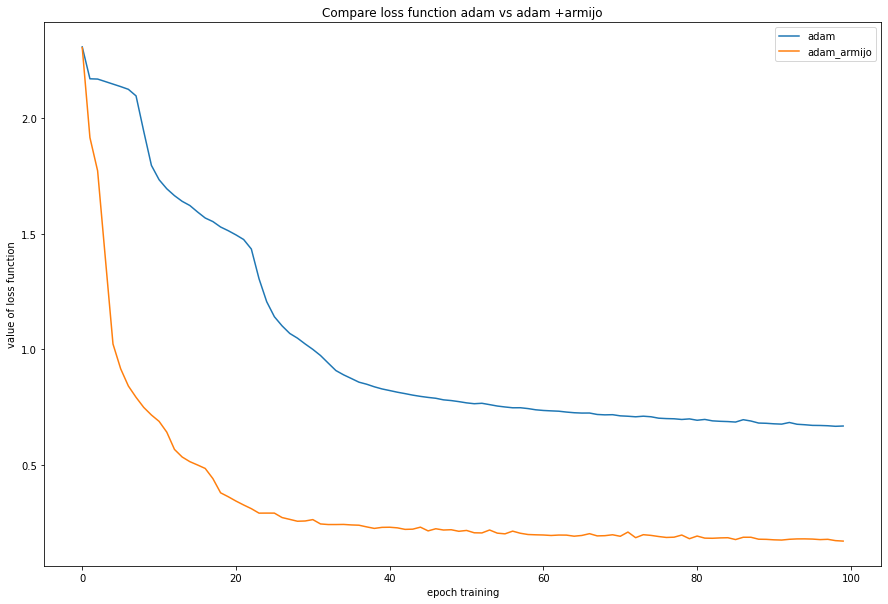

In [ ]:

result_train_loss.plot( y=['adam','adam_armijo'],figsize=(15, 10),title='Compare loss function adam vs adam +armijo',xlabel='epoch training',ylabel='value of loss function')
pass

In [ ]:
accuracy_adam=adam_result1['val_acc']
accuracy_adam_armijo=adam_armijo2_result['val_acc']
result_accuracy = pd.concat([accuracy_adam, accuracy_adam_armijo], axis=1)

In [ ]:
result_accuracy.columns=['adam','adam_armijo']
result_accuracy

adam  adam_armijo
0   0.1238       0.1082
1   0.2405       0.5018
2   0.2427       0.5624
3   0.2617       0.6386
4   0.2713       0.6865
..     ...          ...
95  0.7985       0.9387
96  0.7952       0.9373
97  0.7976       0.9378
98  0.7986       0.9388
99  0.7992       0.9386

[100 rows x 2 columns]

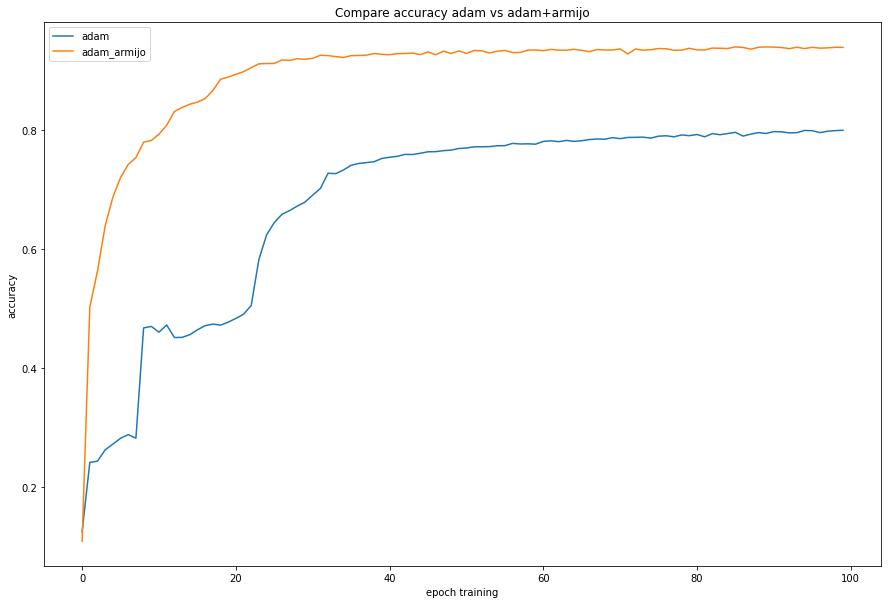

In [ ]:
result_accuracy.plot( y=['adam','adam_armijo'],figsize=(15, 10),title='Compare accuracy adam vs adam+armijo',xlabel='epoch training',ylabel='accuracy')
pass